# Project
---
## **주제와 목적**
최근 북미, 유럽, 일본, 그외 지역에서의 게임 판매량 데이터를 분석하고  
분석을 바탕으로 다음 분기 어떤 게임을 설계 할 것인지 정하는것이다  

---
## **게임을 설계하기 위해서 무엇을 고려해야할까?**
게임을 설계하는 방향은 "판매량이 많은 게임" 을 만드는 것이다  
그러므로 게임의 판매량에 영향을 주는 요인이 무엇인지 확인하고  
그 요인들을 바탕으로 게임의 장르, 플랫폼을 선택해야한다.

---
### **1. 장르는 어떻게 선택할까?**

우선 장르와 지역, 연도의 관련성을 분석해보자
1. 지역별 장르의 선호도가 다를까?
2. 연도별 장르의 트랜드가 있는가?

이 과정을 통해 장르와 연관성 있는것을 찾아낸다  

---
### **2. 플랫폼은 어떻게 선택할까?**

플랫폼과 판매량의 관련성을 분석해보자
1. 지역별 플랫폼의 선호도가 다를까?
2. 플랫폼과 장르는 연관이 있을까?

---
### **3. 출고량이 많은 게임을 분석해보자**
출고량이 많은 게임들을 기준을 세워 분석해보자
1. 출고량이 많은 게임들의 장르 분포는?
2. 출고량이 많은 게임들의 플랫폼 분포는?
3. 기타 고려할 사항들은?
---
### **4. 분석방향**
1,2번에서 분석한 장르와 플랫폼에 관련있는 사항들을 고려하여  
출고량이 많은 게임들의 분석결과에 적용시키면  
어떤 장르와 플랫폼을 골라야 하는지,  
골랐다면 지역을 신경써야하는지 결론 내릴 수 있다.

---
## **결론**
1~4번 과정을 통해  
**"어떤 장르의 게임을 어떤 플랫폼으로 어디에 출시할지"**  
설계 방향을 정할 수 있어야 한다


---

분석을 시작하기전에, 데이터를 좀더 깔끔하게 다듬는 전처리 작업을 진행하였다 

---
# 전처리작업(EDA)
우선 데이터내의 수치를 일관성있게 통일하기위해 전처리작업을 진행하였다  
전처리작업이란, 숫자의단위나 알파벳의 대소문자의 통일, 알수없는값이나 비어있는값을 처리하여 데이터의 오류를 줄이는 과정이다.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [306]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/AI_bootcamp/vgames2.csv', encoding='CP949')

# 인덱스제거
df = df.drop(['Unnamed: 0','Name','Publisher'], axis=1)

In [307]:
# 데이터 전처리하기


# 판매량을 (0.00) 단위로 통일하고 float으로 변경하는 함수 선언
def unification(string):
    # K가 있다면 지우고 천 곱하고 백만으로 나누기
    if ('K' in string) == True:
        # 만약 0K 라면 0.001로 바로바꾸기
        if string == '0K':
            return float(0.001)
        else:
            remove_k = string.replace('K','')
            return float(remove_k)*0.001
    # M이 있다면 지우기
    elif ('M' in string) == True:
        # 만약 OM 이라면 1.0으로 바꾸기
        if string == '0M':
            return float(1.0)
        else:
            remove_m = string.replace('M','')
            return float(remove_m)
    # 둘다없다면 타입만바꾸기
    else:
        return float(string)

# 판매량 칼럽의 단위통일시키기
df['NA_Sales'] = df['NA_Sales'].apply(unification)
df['JP_Sales'] = df['JP_Sales'].apply(unification)
df['EU_Sales'] = df['EU_Sales'].apply(unification)
df['Other_Sales'] = df['Other_Sales'].apply(unification)

# datatype이 object->float으로 되었는지 확인
df.dtypes


Platform        object
Year           float64
Genre           object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

---
# 1. 장르는 어떻게 선택할까?
---
## 지역별 장르의 선호도는 다를까?  
- 장르들의 지역별 판매량이 비슷하다면  ->  선호도가 비슷하다  
- 장르들의 지역별 판매량이 다르다면  ->  선호도가 다르다  


In [309]:
# 장르와 판매량만 포함하는 df2 선언후 결측치 처리
df2 = df
df2 = df2.drop(['Year','Platform'],axis=1)
df2 = df2.dropna()
df2.isna().sum()
df2.head()

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Action,0.04,0.00,0.00,0.00
1,Action,0.17,0.00,0.00,0.01
2,Adventure,0.00,0.00,0.02,0.00
3,Misc,0.04,0.00,0.00,0.00
4,Platform,0.12,0.09,0.00,0.04


In [310]:
# 장르 선호도 비교해보기

# 장르들 목록 선언
genres = ['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy']

# 각 장르에대한 지역별 판매량 비교
for genre in genres:
    genre_data = df2[df2['Genre'] == genre]
    result = f_oneway(genre_data['NA_Sales'],genre_data['JP_Sales'],genre_data['EU_Sales'],genre_data['Other_Sales'])
    print(genre, '/p-value =', result[1])

# 여기서의 " 귀무가설 = 지역간 장르별 판매량은 차이가없다 "
# 하지만 장르들의 p-value 값이 모두 0.05보다 현저히 작으므로 귀무가설을 기각할수 있다
# 즉 "각 지역간의 장르별 판매량은 차이가 있다" (지역별 장르의 선호도는 다르다)

Action /p-value = 9.917382232427142e-147
Adventure /p-value = 2.0945837982584205e-20
Fighting /p-value = 1.2330556384385163e-43
Misc /p-value = 6.440700553325507e-43
Platform /p-value = 3.476396668290617e-28
Puzzle /p-value = 7.747629545653912e-07
Racing /p-value = 5.541020506203407e-39
Role-Playing /p-value = 2.1695107684387342e-27
Shooter /p-value = 1.8083226259160457e-63
Simulation /p-value = 1.0172201539635495e-21
Sports /p-value = 1.4237698139211029e-39
Strategy /p-value = 2.6194762348013894e-12


---
## 연도별 게임의 트랜드가 있을까?

- 연도의 장르별 판매량이 다르다면 - > 트랜드가 있다
- 연도의 장르별 판매량이 비슷하다면 - > 트랜드가 없다 


In [312]:
# 연도와 장르,판매량 포함한 df3 선언후 결측치 처리
df3 = df.drop('Platform',axis=1).dropna()
df3.isna().sum()

# 네자리로 통일시킨후 catogorical 하게 바꾸는 함수 선언
def make_year(year):
    if year < 21:
        return str(year+2000)
    elif year > 80 and year <= 99:
        return str(year+1900)
    else:
        return str(year)

# apply 사용해서 단위 통일
df3['Year'] = df3['Year'].apply(make_year)
df3.dtypes

Year            object
Genre           object
NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

In [313]:
from scipy.stats import ttest_1samp

# 연도와 장르별 총 판매량을 나타내는 데이터프레임 선언
df3['Total'] = df3['NA_Sales'] + df3['JP_Sales'] + df3['EU_Sales'] + df3['Other_Sales']

df_year_genre = df3.loc[:,['Year','Genre','Total']]


years = sorted(df_year_genre.Year.unique())

# 각 년도별 장르의 판매량을 단일t-test하여 p-value 찾기
for year in years:
    df_year = df_year_genre[df_year_genre['Year'] == year]
    df_year = df_year.drop('Year',axis=1)
    result = df_year.groupby('Genre').sum()
    print(year, 'p-value =', ttest_1samp(result.Total, .5).pvalue)

# 여기서의 귀무가설은 연도내에서 장르들의 판매량은 차이가없다
# 1991년도 이후 p-value 값이 0.05보다 작으므로 귀무가설 기각
# 연도내에서 장르들의 판매량은 차이가 있다, 즉 연도별 트랜드가 있다

1980.0 p-value = 0.24459674030407155
1981.0 p-value = 0.07466456063423615
1982.0 p-value = 0.029252839150856514
1983.0 p-value = 0.07141212851668743
1984.0 p-value = 0.15085092647917114
1985.0 p-value = 0.2698099895987587
1986.0 p-value = 0.025617598721504594
1987.0 p-value = 0.010817995665639705
1988.0 p-value = 0.13628612185234243
1989.0 p-value = 0.1039589968757798
1990.0 p-value = 0.05572617213049469
1991.0 p-value = 0.007927449605955157
1992.0 p-value = 0.002128384090813836
1993.0 p-value = 0.04481744445603272
1994.0 p-value = 0.016677184597609827
1995.0 p-value = 0.0006353026385446525
1996.0 p-value = 0.0006439720650256627
1997.0 p-value = 0.00016079559085433793
1998.0 p-value = 0.00014008923976103222
1999.0 p-value = 0.00020782071010839263
2000.0 p-value = 0.0010549574981376908
2001.0 p-value = 0.0003411432104538389
2002.0 p-value = 0.0010166652954320416
2003.0 p-value = 0.000692649939401702
2004.0 p-value = 0.00043434654468725196
2005.0 p-value = 0.0002537157317036536
2006.0 p-

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


---

# 2. 플랫폼은 어떻게 선택할까?
---

## 플랫폼과 지역별 판매량은 연관이있을까?




In [314]:
# 플랫폼과 지역별 판매액만 나타내는 데이터프레임 선언, 결측치제거
df4 = df.drop(['Year','Genre'],axis=1)
df4 = df4.dropna()
df4.head()

,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,DS,0.04,0.00,0.00,0.00
1,Wii,0.17,0.00,0.00,0.01
2,PSP,0.00,0.00,0.02,0.00
3,DS,0.04,0.00,0.00,0.00
4,PS3,0.12,0.09,0.00,0.04


In [315]:
# 플랫폼 리스트 선언
platforms = ['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64',
       'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV',
       'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB',
       'XOne']

# 각 플랫폼별 데이터 분리
def makePlatform(df):
    for platform in platforms:
        platform_data = df[df['Platform'] == platform]
        result = f_oneway(platform_data['NA_Sales'],platform_data['JP_Sales'],platform_data['EU_Sales'],platform_data['Other_Sales'])
        print(platform, '/p-value =', result[1])

makePlatform(df4)

# 귀무가설은 지역별 플랫폼 분포는 차이가 없다
# 결과는 아주오래된 몇개의 플랫폼을 제외하고는 모두 0.05보다 훨씬 낮은 p-value값을 가졌다
# 그러므로 귀무가설을 기각할 수 있고, 지역별 플랫폼의 분포는 차이가 있다 고 판단할 수 있다
# 즉 지역별 플랫폼의 선호도는 다르다

2600 /p-value = 3.136406828910054e-42
3DO /p-value = 0.017162023580482293
3DS /p-value = 9.455209761154263e-10
DC /p-value = 0.00025256814746011486
DS /p-value = 7.303193580388891e-31
GB /p-value = 0.00017150874520351794
GBA /p-value = 2.2205794111493737e-53
GC /p-value = 7.714143836255033e-62
GEN /p-value = 0.0002372932225412577
GG /p-value = nan
N64 /p-value = 1.1672258273331049e-31
NES /p-value = 4.8735256244936565e-05
NG /p-value = 1.0011788008419206e-09
PC /p-value = 2.180888936680166e-34
PCFX /p-value = nan
PS /p-value = 2.2098341986663434e-58
PS2 /p-value = 1.0035671961679485e-71
PS3 /p-value = 2.372704652390955e-56
PS4 /p-value = 4.3547886105079335e-17
PSP /p-value = 1.7909100328021057e-11
PSV /p-value = 0.006047894173131857
SAT /p-value = 1.7092865289945671e-65
SCD /p-value = 0.6543526382795086
SNES /p-value = 2.6965843101790935e-16
TG16 /p-value = 0.29035241802349165
WS /p-value = 5.5371926648596975e-05
Wii /p-value = 5.524957156652667e-22
WiiU /p-value = 1.33240566024685e-07

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3348: RuntimeWarning: invalid value encountered in double_scalars
  msw = sswn / dfwn


## 플랫폼은 연도별 트랜드가 있을까?

In [317]:
# 플랫폼과 연도별 데이터 정리
df_pl_ye = df.drop('Genre',axis=1).dropna()
df_pl_ye['Total'] = df_pl_ye['NA_Sales']+df_pl_ye['JP_Sales']+df_pl_ye['EU_Sales']+df_pl_ye['Other_Sales']
# apply 사용해서 단위 통일
df_pl_ye['Year'] = df_pl_ye['Year'].apply(make_year)
df_pl_ye = df_pl_ye.dropna()

df_pl_ye = df_pl_ye[['Platform','Year','Total']]

# 같은 플랫폼일때 연도별 판매량 비교
for year in years:
    df_year = df_pl_ye[df_pl_ye['Year'] == year]
    df_year = df_year.drop('Year',axis=1)
    result = df_year.groupby('Platform').sum()
    print(year, 'p-value =', ttest_1samp(result.Total, .5).pvalue)

# 귀무가설 연도별 플랫폼의 판매량은 차이가없다
# 대부분의 p-value 값이 0.05보다 크다 -> 귀무가설 기각할수 없다
# 즉 연도별 플랫폼판매량은 차이가없다, 플랫폼은 연도별 트랜드가없다.

1980.0 p-value = nan
1981.0 p-value = nan
1982.0 p-value = nan
1983.0 p-value = 0.19949944126604433
1984.0 p-value = 0.5029531775753187
1985.0 p-value = 0.40138732876169747
1986.0 p-value = 0.49706787873104263
1987.0 p-value = 0.4524906543041226
1988.0 p-value = 0.3825151466168577
1989.0 p-value = 0.35981212352264214
1990.0 p-value = 0.11682507119190999
1991.0 p-value = 0.07063551677071056
1992.0 p-value = 0.08181943394267667
1993.0 p-value = 0.31224253578214434
1994.0 p-value = 0.056211991733741674
1995.0 p-value = 0.08604766591663356
1996.0 p-value = 0.0646414613060476
1997.0 p-value = 0.17983638584931744
1998.0 p-value = 0.16932873669712914
1999.0 p-value = 0.12784649639173523
2000.0 p-value = 0.07026491405117498
2001.0 p-value = 0.07071900782487342
2002.0 p-value = 0.08196928700988874
2003.0 p-value = 0.07472400024289637
2004.0 p-value = 0.07170274398081429
2005.0 p-value = 0.025268512878073843
2006.0 p-value = 0.011336115552060131
2007.0 p-value = 0.011168839510745723
2008.0 p-val

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 플랫폼과 장르는 연관이 있을까?
- 같은 장르라면, 플랫폼에따라 판매량에 차이가 있는지 확인해보자


In [318]:
# 플랫폼 장르 총판매량 나타내는 데이터프레임 선언
df6 = df.drop('Year',axis=1)
df6['Total'] = df6['NA_Sales'] + df6['JP_Sales'] + df6['EU_Sales'] + df6['Other_Sales']
df6 = df6[['Platform','Genre','Total']]
df6 = df6.dropna()

# 플랫폼별 장르의 판매량 나타내는 함수 선언
platforms = df.Platform.unique()

def platformGenre(df):
    df_empty = pd.DataFrame(columns=df.Genre.unique())
    for platform in platforms:
        plat = df[df['Platform'] == platform]
        plat = plat[['Genre','Total']]
        result = plat.groupby('Genre').sum().T
        result = result.rename(index={'Total': platform})
        df_empty = pd.concat([df_empty,result])
    return df_empty

# 확인
df_plat_gen = platformGenre(df6)
df_plat_gen.head()

,Action,Adventure,Misc,Platform,Sports,Simulation,Racing,Role-Playing,Puzzle,Strategy,Fighting,Shooter
DS,119.381,51.251,145.607,77.392,33.762,133.566,38.591,127.772,85.830,17.330,7.200,9.101
Wii,119.422,18.361,216.136,90.751,294.073,36.821,64.131,14.080,15.572,6.240,23.841,28.590
PSP,65.725,15.682,16.940,16.560,44.750,6.290,35.710,53.960,5.422,11.592,21.981,19.801
PS3,308.342,22.880,52.761,30.220,137.673,10.760,74.941,75.381,0.590,4.951,51.712,196.040
PC,32.511,10.033,9.540,0.470,12.973,53.771,6.032,48.633,0.930,47.683,0.270,46.222


In [319]:
# 같은 장르내에서 플랫폼별 판매량의 차이가 다른지 확인
for column in df_plat_gen.columns:
    ttest = ttest_1samp(df_plat_gen[column].dropna(),.5)
    print(column, "/p-value =", ttest.pvalue)

# 귀무가설 = 같은 장르일때 플랫폼별 판매량차이는 없다
# p-value가 모두 0.05보다 작다 -> 귀무가설 기각
# 장르의 판매량과 플랫폼은 연관이 있다

Action /p-value = 0.0003726899003919444
Adventure /p-value = 0.00036377270003170074
Misc /p-value = 0.0051380953994127395
Platform /p-value = 3.0405762924314426e-05
Sports /p-value = 0.0029072697108501193
Simulation /p-value = 0.011866741740473632
Racing /p-value = 0.0008550342727190338
Role-Playing /p-value = 5.158692940259852e-05
Puzzle /p-value = 0.018706909776241752
Strategy /p-value = 0.002228983556135935
Fighting /p-value = 0.0009260042200852938
Shooter /p-value = 0.004645152696081308


---
## 판매량과 다른 요소들의 관계를 비교해보자  
---
위의 분석들을 통해 다음과 같은 결론을 내릴 수 있다  

1. 지역별 선호하는 장르가 다르다.
2. 연도별 장르의 트랜드가 있다.
3. 지역별 선호하는 플랫폼이 다르다.
4. 플랫폼별 장르의 판매량은 차이가있다.

이 조건들을 고려해본다면,  
판매량이 높은 게임의 장르를 확인해 장르를 고른 후,  
그 장르가 많이팔리는 플랫폼과 지역을 찾아 적용해야 한다  

그럼 판매량이 높은 게임들을 분석해보자



---
# 3. 출고량이 많은 게임을 분석하고 시각화해보자
---

출고량이 많은 게임들을 기준을 세워 분석해보자

- 그럼 가장 먼저 고려해야하는것은 무었일까?  
분석한 바로는 장르와 플랫폼 모두 판매량과 연관이있다.  
- 그러므로 상위 판매량을 분석하여 보다 뚜렷하게 차이가 나타나는 기준을 선택한다.  
- 예를들어 게임장르의 분포는 비슷한데, 플랫폼의 분포가 확실히 구분된다면 먼저 플랫폼을 정하는것이 유리하다.  

그 다음 정해진 장르나 플랫폼을 기준으로 나머지 조건을 고려해보자 

In [323]:
# 총판매량 오름차순 정리해서 살펴보기
df_total = df
df_total['Total'] =  df_total['NA_Sales'] + df_total['JP_Sales'] + df_total['EU_Sales'] + df_total['Other_Sales']
df_total = df.sort_values(by=['Total'],ascending=False)
df_total['Year'] = df_total['Year'].apply(make_year)

df_total.head()

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
2908,Wii,2006.0,Sports,41.49,29.02,3.77,8.46,82.74
4199,NES,1985.0,Platform,29.08,3.58,6.81,0.77,40.24
12579,Wii,2008.0,Racing,15.85,12.88,3.79,3.31,35.83
3352,Wii,2009.0,Sports,15.75,11.01,3.28,2.96,33.00
7829,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,31.38


In [324]:
# 판매량 상위 10% 게임 설정
df_total = df_total[:1600]
df_total

#상위 10%에서의 기준별 총판매량 나타내는 함수선언
def show_10per(about):
    df_y_t = df_total[[about,'Total']]
    df_y_t = df_y_t.dropna()

    df_y_t = df_y_t.groupby(about).sum()
    df_y_t = df_y_t.sort_values(by=['Total'], ascending = False)[:6]
    # bar plot 시각화
    sns.barplot(data = df_y_t, x = df_y_t.index , y = 'Total')
    plt.show()

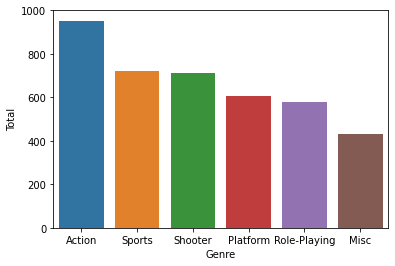

In [325]:
# 장르와 총판매량
show_10per('Genre')

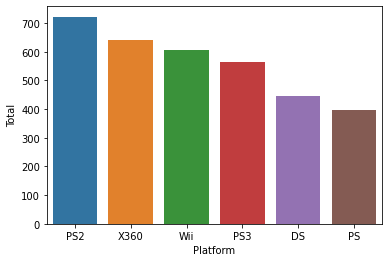

In [326]:
# 플랫폼과 판매량
show_10per('Platform')

## 장르는 액션, 플랫폼은 PS2 가 많다
- 하지만 장르의 1,2위 차이는 약 200M
- 플랫폼의 1,2위 차이는 약 50M 으로
- 장르가 더 확실한 차이를 보인다
- 그러므로 장르를 액션으로 정하자

In [337]:
# 판매량이 많은 게임들 중 액션장르만 포함하는 데이터를 다시 확인해보자
# 액션장르가 잘팔리는 플랫폼, 지역을 찾아서 선택하자

df_action = df_total[df_total['Genre']=='Action']
df_action.head()

,Platform,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
3483,PS3,2013.0,Action,7.01,9.27,0.97,4.14,21.39
14669,PS2,2004.0,Action,9.43,0.40,0.41,10.57,20.81
10913,X360,2013.0,Action,9.63,5.31,0.06,1.38,16.38
5340,PS2,2002.0,Action,8.41,5.49,0.47,1.78,16.15
9786,PS2,2001.0,Action,6.99,4.51,0.30,1.30,13.10


In [341]:
# 플랫폼과 지역별 판매량, 총판매량
df_action_drop = df_action.drop(['Year','Genre'],axis=1)

df_action_total = df_action.groupby('Platform').sum()
df_action_total.sort_values(by=['Total'],ascending=False)

# 액션게임이 제일잘팔리는 플랫폼은 PS3,PS2,X360 정도다
# 그리고 이 판매량중 북미의 판매량이 가장 많았다

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total
Platform,,,,,
PS3,75.68,71.84,8.58,30.68,186.78
PS2,79.43,46.55,11.05,30.99,168.02
X360,85.32,49.12,2.33,13.58,150.35
PS,44.66,32.42,8.08,5.20,90.36
PS4,21.16,28.00,2.13,10.04,61.33
Wii,30.50,16.64,1.66,4.95,53.75
DS,25.50,15.71,6.72,4.47,52.40
NES,15.35,3.08,6.68,0.41,25.52
3DS,7.48,4.64,9.32,1.12,22.56


---
# 결론
---

액션장르의 게임을 PS3,PS2,X360 플랫폼으로 북미,유럽을 대상으로 설계하는것이 좋다.

# 임시정보

In [271]:
# 총판매량의 상위20% 확인해보기 
# for i in range(0,len(df_total.Total)):
#     result = ((df_total.Total.sum() - (df_total.Total[0:i]).sum())/df_total.Total.sum())*100
#     print(result,'%',i)
# 상위 21개의 의 판매량합이 상위 20% 임을 확인


In [ ]:
# 연도,판매량, 플랫폼
# df_year_plat = df_total
# df_year_plat = df_year_data[['Platform','Year','Total']]

# # df_year_plat = df_year_plat[df_year_plat['Year'] > 2000]
# df_year_plat

# sns.scatterplot(data=df_year_plat,x='Year',y='Total',hue='Platform')

# # 거의 대부분이 Will, DS 임을 확인